# PyTorch Workflow

In this Notebook  i'll try to implement an end-to-end workflow.

![](pytorch_workflow.png)

In [1]:
coverage = {
    1: "Prepare and Load the data",
    2: "build model",
    3: "fit model to data",
    4: "make and evaluate predictions",
    5: "save and load a model",
    6: "put it all together"
}
coverage

{1: 'Prepare and Load the data',
 2: 'build model',
 3: 'fit model to data',
 4: 'make and evaluate predictions',
 5: 'save and load a model',
 6: 'put it all together'}

In [2]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Data (preparing and loading)

Data can be almost anything...

- Spreadsheets
- Images
- Videos
- Audio
- DNA
- Text

Machine learning is a game of two phases:
1. Get data into numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this,  let's create some *known* data using the linear regression formula.

We'll use the formula to make a straight line with *known* **parameters**.

In [3]:
# Create known parameter
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### 1.1. Splitting data into training and test sets (AGAIIIN)
Let's create a training and test set with our dataset.

In [5]:
# Create the train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [8]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots the data and compares predictions.
    """
    fig, ax = plt.subplots(figsize=(10, 7))

    # Training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")

    # Testing data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    plt.legend(prop={"size":14});

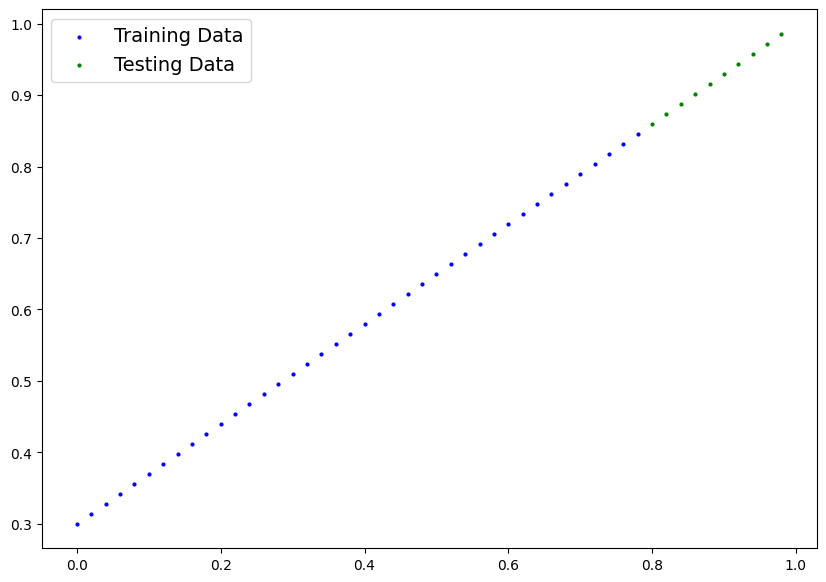

In [9]:
# Visualize the training data
plot_predictions()

## 2. Build model 

First Model using PyTorch!

What does it do:
- It's a Linear regression, nothing complicated.
- Gradient Descent + BackPropagation ...

In [16]:
# Create Linear regression model
class LinearRegressionModel(nn.Module): # everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # Starts with a random weight and tries to adjust it to the ideal weight
                                                requires_grad=True, # Can this parameter be updated via gradient descent?
                                                dtype=torch.float32)) # PyTorch works better with torch.float32
        self.bias = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float32))
    
    # Forward Method to define the computation int he model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input ofc
        return self.weights * x + self.bias

### PyTorch model building essentials

- torch.nn - contains all of the buildings for computational graphs
- torch.nn.Parameter - what parameters should our model learn, often a PyTorch layer from torch.nn will set these for us
- torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
- torch.optim - this is where the optimizers in PyTorch are, they help with gradient descent
- def forward() - All nn.Module subclasses require you to ovewrite forward(), this method defines what happens in the forward computation

### Checking the contents of our model

Let's see what's inside the model.

the best way to check the models parameters is `.parameters()`.

In [116]:
# Create Random seed
torch.manual_seed(42)

# Create an instance of the model (subclass of nn.Module)
model_0 = LinearRegressionModel()
model_0

LinearRegressionModel()

In [117]:
# Check the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [118]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check the model's predictive power, lessee how well it predicts `y_test` based on `X_test`.

When we pass the data to our model, it runs it through the `forward()` method.

In [119]:
# MAke predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds, y_test

(tensor([[0.3982],
         [0.4049],
         [0.4116],
         [0.4184],
         [0.4251],
         [0.4318],
         [0.4386],
         [0.4453],
         [0.4520],
         [0.4588]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

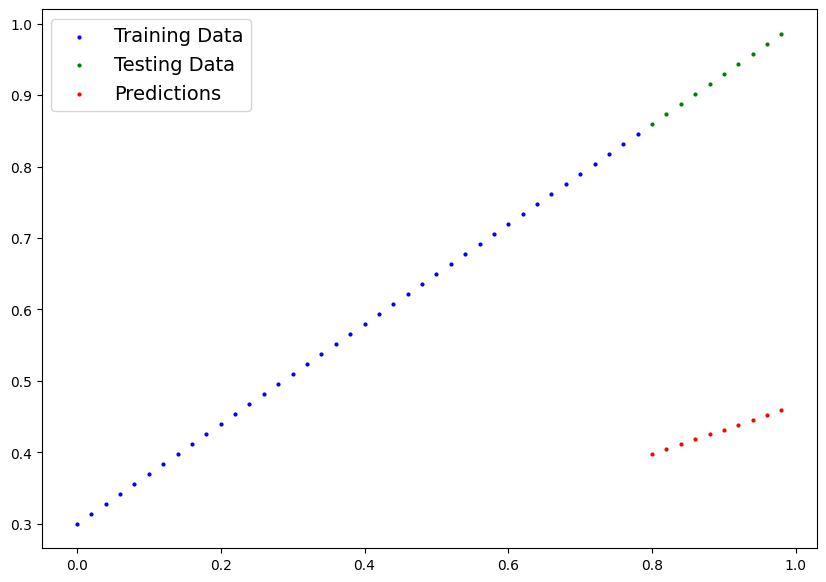

In [120]:
plot_predictions(predictions=y_preds)

## 3. Train model

we train models so they can move from *unknown* parameters to *known* ones.

One way to measure how poor the model's predictions are, we can use a loss/cost function.

- **Note:** Loss function may also be called cost function or criterion.

Things we need to train:
- **Loss function:** a function to measure how wrong a model's predictions are to ideal output (lower the better).
- **Optimizer:** takes into account the loss of a model and adjust the parameters accordingly.

For PyTorch we need:
- Training loop
- Testing loop

In [121]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [122]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochatic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.001)

### Building a training and a testing loop in PyTorch

Things needed in a trainin loop:

0. Loop through the data
1. Forward pass also called forward propagation to make predictions
2. Calculate the loss (Compare predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through  the network to calcilate the gradients of each parameter with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameter to improve the loss (**gradient descent**)

In [123]:
# An epoch is one loop through the data (equivalent of n_iters in sklearn)
epochs = 2000

epoch_vals = []
loss_vals = []
test_loss_vals = []

###  Training
# 0. Loop though data
for epoch in range(epochs):
    # Set model to tainin mode
    model_0.train() # train mode in PyTorch sets all parameters that require gradient to require gradient

    # 1. Forward pass
    y_pred = model_0(X_train)
    
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad() # reset optimizer gradient for each new loop
    
    # 4. Perform backpropagation on the loss
    loss.backward()
    
    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()
    
    ### Testing
    model_0.eval() # turns off different setting no needed for evaluation
    with torch.inference_mode():
        # 1. Do the forward pass
        test_preds = model_0(X_test)
        
        # 2. Calculate the loss
        test_loss = loss_fn(test_preds, y_test)
    # print out what's happenin'
    if epoch % 100 == 0:
        epoch_vals.append(epoch)
        test_loss_vals.append(test_loss)
        loss_vals.append(loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
        print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.4931890368461609
OrderedDict({'weights': tensor([0.3371]), 'bias': tensor([0.1298])})
Epoch: 100 | Loss: 0.19767141342163086 | Test loss: 0.35847947001457214
OrderedDict({'weights': tensor([0.3761]), 'bias': tensor([0.2298])})
Epoch: 200 | Loss: 0.08973254263401031 | Test loss: 0.22795839607715607
OrderedDict({'weights': tensor([0.4150]), 'bias': tensor([0.3257])})
Epoch: 300 | Loss: 0.05357731133699417 | Test loss: 0.15086300671100616
OrderedDict({'weights': tensor([0.4485]), 'bias': tensor([0.3730])})
Epoch: 400 | Loss: 0.04549176245927811 | Test loss: 0.11657620966434479
OrderedDict({'weights': tensor([0.4730]), 'bias': tensor([0.3855])})
Epoch: 500 | Loss: 0.04160415381193161 | Test loss: 0.10088418424129486
OrderedDict({'weights': tensor([0.4924]), 'bias': tensor([0.3839])})
Epoch: 600 | Loss: 0.03811401128768921 | Test loss: 0.08986451476812363
OrderedDict({'weights': tensor([0.5104]), 'bias': tensor([0.3789])})
Epoch: 700 | Los

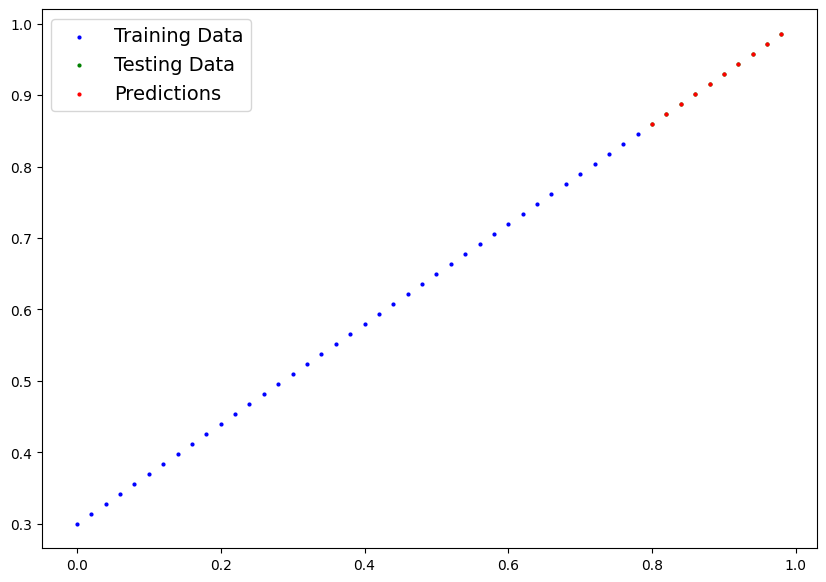

In [124]:
# MAke predictions with model
with torch.inference_mode():
    y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds_new)

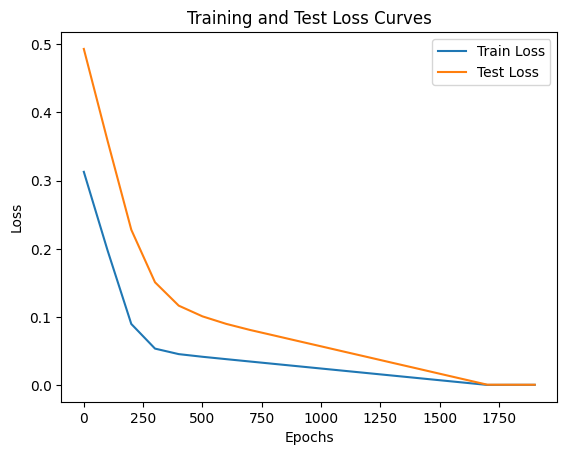

In [129]:
# plot the loss curves
plt.plot(torch.tensor(epoch_vals).numpy(), torch.tensor(loss_vals).numpy(), label="Train Loss")
plt.plot(epoch_vals, test_loss_vals, label="Test Loss")
plt.title("Training and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

## 4. Saving and Loading a model in PyTorch
### Saving a model

There are three ways for saving and loading models in PyTorch.

1. `torch.save()` - allowd you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load model's saved state dictionary.

In [132]:
# Saving the model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create Model save path
MODEL_NAME = "pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model's state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/pytorch_workflow_model_0.pth


### Loading a model

Since we saved our models state dict we'll create a new instance if our model class and load the state dict

In [133]:
# To load in a saved state dict we have to instatiate a new instance
loaded_model_0 = LinearRegressionModel()

# Load the saved state dict of model_0
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

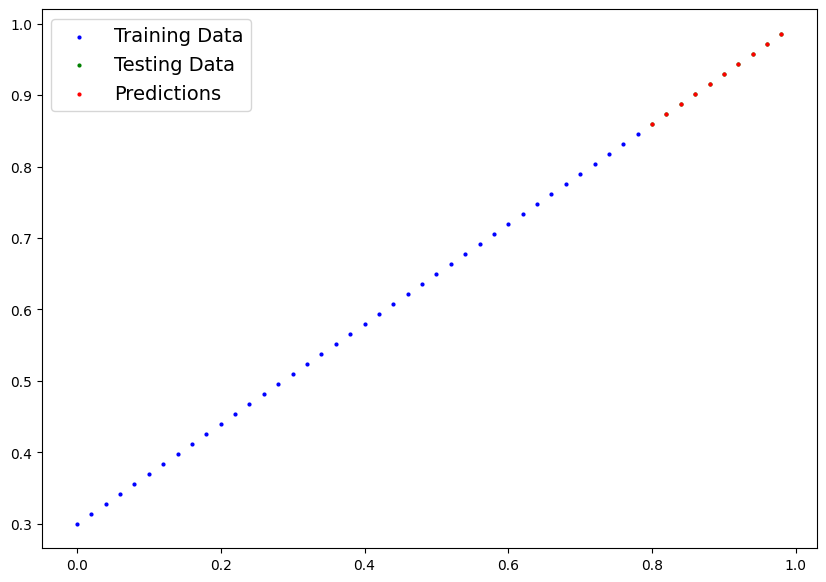

In [134]:
# MAke predictions with the loaded model
loaded_model_0.eval()
with torch.inference_mode():
    y_preds_loaded = loaded_model_0(X_test)

plot_predictions(predictions=y_preds_loaded)